In [9]:
import sys
print(sys.executable)

E:\anaconda3\envs\tensorflow21gpu\python.exe


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from IPython.display import clear_output
%matplotlib inline

import tensorflow as tf
# import tensorflow_addons as tfa

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))
print(tf.config.list_physical_devices('GPU'))

tensorflow version: 2.1.0
GPU 사용 가능 여부: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
train_pandas = pd.read_csv("train_job/train.csv")
train_usertags_pandas = pd.read_csv("train_job/user_tags.csv")
train_jobtags_pandas = pd.read_csv("train_job/job_tags.csv")
train_jobcompanies_pandas = pd.read_csv("train_job/job_companies.csv")

In [12]:
from collections import defaultdict
usertagdict = defaultdict(list)
for u, t in train_usertags_pandas.values:
    usertagdict[u].append(t)
jobtagdict = defaultdict(list)
for j, t in train_jobtags_pandas.values:
    jobtagdict[j].append(t)

In [13]:
avg_usertag = sum(list(map(len,usertagdict.values()))) // len(usertagdict)
avg_jobtag = sum(list(map(len,jobtagdict.values()))) // len(jobtagdict)
print(avg_usertag, avg_jobtag)

87 4


In [14]:
train = train_pandas[:]

In [15]:
train['usertagnum'] = avg_usertag
train['jobtagnum'] = avg_jobtag
train['uniontagnum'] = 0

In [16]:
for i,(u,j) in enumerate(train[['userID','jobID']].values):
    train.loc[i,'usertagnum'] = len(usertagdict[u])
    train.loc[i,'jobtagnum'] = len(jobtagdict[j])
    train.loc[i,'uniontagnum'] = len(set(usertagdict[u]) & set(jobtagdict[j]))

In [17]:
train.to_csv('prac1_train1.csv')

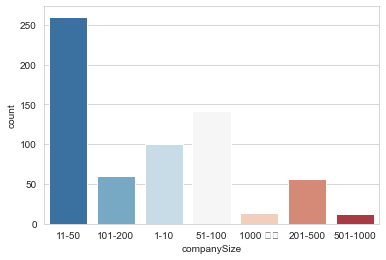

In [18]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='companySize',data=train_jobcompanies_pandas,palette='RdBu_r')

In [19]:
train_jobcompanies = train_jobcompanies_pandas[:]
train_jobcompanies['companySize'] = train_jobcompanies['companySize'].fillna('11-50')

In [20]:
companysizedict = {'1-10':1,'11-50':2,'51-100':3,'101-200':4,'201-500':5,'501-1000':6,'1000 이상':7}

In [21]:
jobsizedict = defaultdict(int)
for j,s in train_jobcompanies[['jobID','companySize']].values:
    jobsizedict[j] = companysizedict[s]

In [22]:
train['companySize'] = 1
for i,(j) in enumerate(train['jobID'].values):
    train.loc[i,'companySize'] = jobsizedict[j]
train.head()

,userID,jobID,applied,usertagnum,jobtagnum,uniontagnum,companySize
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0,151,2,0,2
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0,125,3,1,4
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1,28,3,1,2
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0,85,5,3,2
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0,100,4,1,3


In [23]:
train.to_csv('prac1_train2.csv')

In [24]:
train_set = train[['usertagnum','jobtagnum','uniontagnum','companySize']]
predict_label = tf.cast(tf.one_hot(train['applied'],2), tf.int64)

In [25]:
train_set = (train_set - train_set.mean())/train_set.std()

In [26]:
train_set

,usertagnum,jobtagnum,uniontagnum,companySize
0,0.690519,-1.203109,-1.105259,-0.480536
1,0.375737,-0.837608,-0.327729,0.988244
2,-0.798643,-0.837608,-0.327729,-0.480536
3,-0.108543,-0.106605,1.227332,-0.480536
4,0.073062,-0.472106,-0.327729,0.253854
...,...,...,...,...
5995,0.617877,-1.203109,0.449801,-0.480536
5996,-0.217506,0.258897,1.227332,0.253854
5997,0.339416,2.451906,0.449801,0.988244
5998,-0.713894,-0.472106,-0.327729,0.253854


In [27]:
seed = 7
np.random.seed(seed)

# Model
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(10, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(10, input_dim=4))
model.add(tf.keras.layers.Dense(10))
# model.add(tf.keras.layers.Dense(2, kernel_initializer='normal',activation=tf.nn.softmax))
model.add(tf.keras.layers.Dense(2))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_fit = model.fit(np.array(train_set), np.array(predict_label), epochs=100, batch_size=5, verbose=1,validation_split=0.1)

In [28]:
model.evaluate(np.array(train_set), np.array(predict_label))

In [29]:
test_pandas = pd.read_csv("test_job.csv")

In [30]:
test = test_pandas[:]

test['usertagnum'] = avg_usertag
test['jobtagnum'] = avg_jobtag
test['uniontagnum'] = 0
test['companySize'] = 1
for i,(u,j) in enumerate(test[['userID','jobID']].values):
    test.loc[i,'usertagnum'] = len(usertagdict[u])
    test.loc[i,'jobtagnum'] = len(jobtagdict[j])
    test.loc[i,'uniontagnum'] = len(set(usertagdict[u]) & set(jobtagdict[j]))
    test.loc[i,'companySize'] = jobsizedict[j]

test

,userID,jobID,usertagnum,jobtagnum,uniontagnum,companySize
0,ebaee1af0c501f22ddfe242fc16dae53,352407221afb776e3143e8a1a0577885,143,7,3,2
1,9ab05403ac7808cbfba3da26665f7a9c,96b9bff013acedfb1d140579e2fbeb63,48,7,1,3
2,33349e909eba71677299d2fc97e158b7,58d4d1e7b1e97b258c9ed0b37e02d087,78,7,1,2
3,ac985a9db5faeb44c94a334430ccc241,ccb0989662211f61edae2e26d58ea92f,15,4,0,2
4,d41e0e6f6f1e29098d9d152511503ab2,4a213d37242bdcad8e7300e202e7caa4,100,6,0,2
...,...,...,...,...,...,...
2430,01ed443356f762e9132b58f8c80e131d,26e359e83860db1d11b6acca57d8ea88,82,4,0,5
2431,946aa0c612952da8d67dd338a43d5929,c0f168ce8900fa56e57789e2a2f2c9d0,30,3,2,2
2432,ce840aa9583592e71f3db26ee6e41703,8065d07da4a77621450aa84fee5656d9,170,4,2,2
2433,946aa0c612952da8d67dd338a43d5929,a0160709701140704575d499c997b6ca,30,3,1,2


In [31]:
test.to_csv('prac1_test1.csv')

In [24]:
test_set = test[['usertagnum','jobtagnum','uniontagnum','companySize']].astype(int)

In [25]:
test_set = (test_set - train_set.mean())/train_set.std()

In [26]:
y_predict = model(np.array(test_set))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [27]:
print(y_predict)

tf.Tensor(
[[53.122307  -1.5506598]
 [ 5.237216  -3.7053144]
 [20.172264  -3.0858574]
 ...
 [76.19197    1.6702476]
 [ 8.171829  -1.013764 ]
 [33.246346   0.5612665]], shape=(2435, 2), dtype=float32)


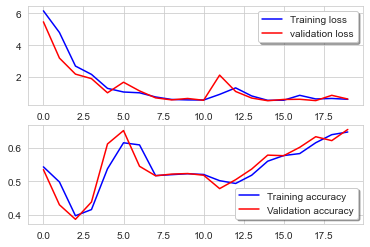

In [28]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_fit.history['loss'], color='b', label="Training loss")
ax[0].plot(history_fit.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_fit.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_fit.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [29]:
val_label_num = np.argmax(y_predict, axis=1).reshape(-1,1)

In [30]:
result = pd.DataFrame(val_label_num,columns=['applied'])

In [31]:
import datetime
now = datetime.datetime.now()
result.to_csv('output_{}.csv'.format(now.strftime('%y_%m_%d_%H_%M_%S')), index=False)